<a href="https://colab.research.google.com/github/sayakpaul/Image-Adversaries-101/blob/master/Adversarial_Training_NSL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we are going to:
- Train an image classification model to classify different flower species.
- Create adversarial examples to launch targeted attcks to the classifier.
- Train an adversarially robust classifier using [`Neural Structured Learning`](https://www.tensorflow.org/neural_structured_learning).

We are primarily going to use TensorFlow for this.

## Training an image classification model to classify different flower species

In [1]:
# TensorFlow version
import tensorflow as tf
print(tf.__version__)

2.2.0-rc2


In [2]:
# Which GPU?
!nvidia-smi

Thu Apr  9 10:30:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# other imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import random
import shutil
import time
import cv2
import os

In [0]:
# Gather Flowers-17 dataset
data_root = tf.keras.utils.get_file(
  "/content/flower_photos", "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz",
   untar=True)

In [0]:
# Untar the dataset
!tar -xvf flower_photos.tar.gz

In [0]:
# Tree for viewing directory structures
!sudo apt-get install tree

In [7]:
!tree --dirsfirst --filelimit 10 flower_photos

flower_photos
├── daisy [633 entries exceeds filelimit, not opening dir]
├── dandelion [898 entries exceeds filelimit, not opening dir]
├── roses [641 entries exceeds filelimit, not opening dir]
├── sunflowers [699 entries exceeds filelimit, not opening dir]
├── tulips [799 entries exceeds filelimit, not opening dir]
└── LICENSE.txt

5 directories, 1 file


In [8]:
# All the paths of the flowers
ALL_IMG_PATHS = list(paths.list_images("flower_photos"))
print(ALL_IMG_PATHS[:10])

['flower_photos/sunflowers/8192234807_fed4a46f1a_n.jpg', 'flower_photos/sunflowers/14741813110_94964c39e2_n.jpg', 'flower_photos/sunflowers/4806174512_e04475b766_n.jpg', 'flower_photos/sunflowers/19697910486_0086d893a2.jpg', 'flower_photos/sunflowers/3196753837_411b03682d_n.jpg', 'flower_photos/sunflowers/4816636411_0135bfe2c9_n.jpg', 'flower_photos/sunflowers/2694860538_b95d60122c_m.jpg', 'flower_photos/sunflowers/16988605969_570329ff20_n.jpg', 'flower_photos/sunflowers/14925398441_107f3e0304_n.jpg', 'flower_photos/sunflowers/5330608174_b49f7a4c48_m.jpg']


In [9]:
# shuffle the image paths and preview
random.shuffle(ALL_IMG_PATHS)
ALL_IMG_PATHS[:5]

['flower_photos/daisy/3750771898_cfd50090ba_n.jpg',
 'flower_photos/roses/8987479080_32ab912d10_n.jpg',
 'flower_photos/sunflowers/2996573407_5e473b9359.jpg',
 'flower_photos/dandelion/16691236594_4287cea9d6_n.jpg',
 'flower_photos/sunflowers/145303599_2627e23815_n.jpg']

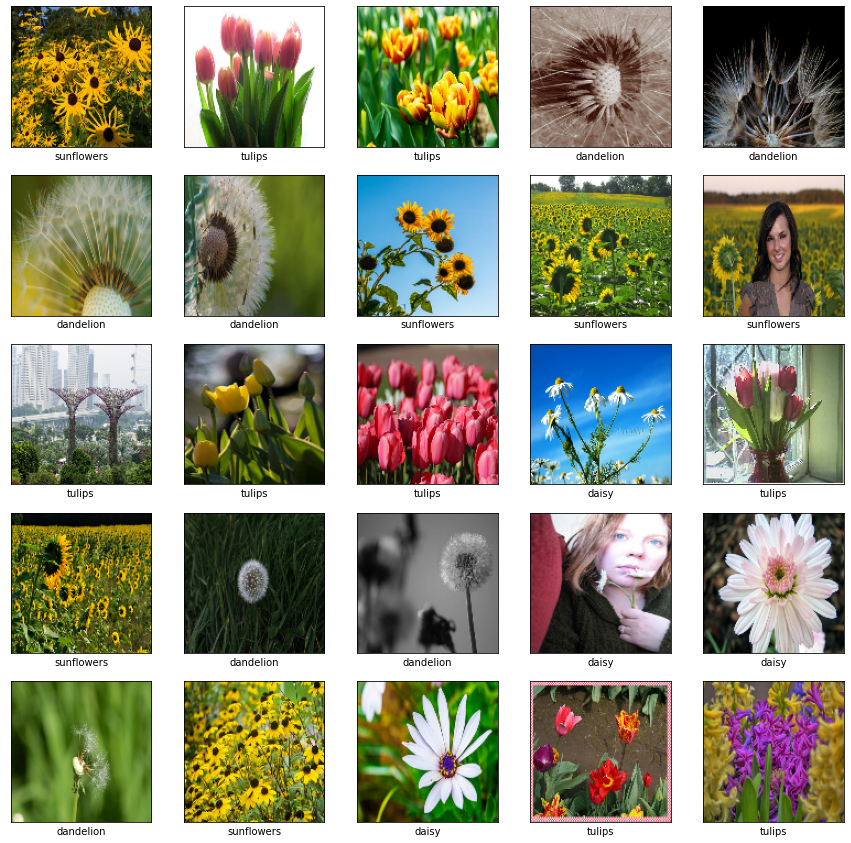

In [10]:
# Visualize images
plt.figure(figsize=(15,15))
for i in range(25):
    image_path = np.random.choice(ALL_IMG_PATHS)
    image = plt.imread(image_path)
    image = cv2.resize(image, (128, 128))
    # you might want to verify the labels before 
    # you put this to use
    label = image_path.split("/")[1]
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.imshow(image)
    plt.xlabel(label)
plt.show()

In [0]:
# going for a 0.15 test split
nb_test_images = int(len(list(paths.list_images("flower_photos"))) * 0.15)
nb_train_images = len(list(paths.list_images("flower_photos"))) - nb_test_images

In [0]:
# specify the directory paths
train_dir = "train"
val_dir = "val"

In [0]:
def move_images(nb_images, output_dir):
    # iterate through the number of images
    for i in tqdm(range(nb_images)):
        # grab an image path and grab the label of the image
        image_path = ALL_IMG_PATHS[i]
        # careful about the index of the split
        label = image_path.split("/")[1]
        
        # check if a directory for the label exists, if not create it
        new_image_dir = os.path.join(output_dir, label)
        if not os.path.exists(new_image_dir):
            os.makedirs(new_image_dir)
            
        # copy the current image to the respective folder
        shutil.copy2(image_path, new_image_dir)

In [14]:
# prepare the train and test set
move_images(nb_train_images, train_dir)
move_images(nb_test_images, val_dir)

100%|██████████| 550/550 [00:00<00:00, 4424.69it/s]


In [15]:
# Verify structures
!tree --dirsfirst --filelimit 10 train
!tree --dirsfirst --filelimit 10 val

train
├── daisy [540 entries exceeds filelimit, not opening dir]
├── dandelion [763 entries exceeds filelimit, not opening dir]
├── roses [542 entries exceeds filelimit, not opening dir]
├── sunflowers [594 entries exceeds filelimit, not opening dir]
└── tulips [681 entries exceeds filelimit, not opening dir]

5 directories, 0 files
val
├── daisy [85 entries exceeds filelimit, not opening dir]
├── dandelion [137 entries exceeds filelimit, not opening dir]
├── roses [111 entries exceeds filelimit, not opening dir]
├── sunflowers [90 entries exceeds filelimit, not opening dir]
└── tulips [127 entries exceeds filelimit, not opening dir]

5 directories, 0 files


In [16]:
# Setup data generators
train_aug = ImageDataGenerator(rescale=1/255.)
val_aug = ImageDataGenerator(rescale=1/255.)

train_gen = train_aug.flow_from_directory("train",
    class_mode="categorical",
    target_size=(224, 224),
	color_mode="rgb",
	shuffle=True,
	batch_size=32
)
val_gen = train_aug.flow_from_directory("val",
    class_mode="categorical",
    target_size=(224, 224),
	color_mode="rgb",
	shuffle=False,
	batch_size=32
)

Found 3120 images belonging to 5 classes.
Found 550 images belonging to 5 classes.


In [0]:
# Load the MobileNetv2 model but exclude the classification layers
EXTRACTOR = MobileNetV2(weights="imagenet", include_top=False,
                    input_shape=(224, 224, 3))

In [0]:
def get_training_model():
    # We are not training the extractor model
    EXTRACTOR.trainable = False
    # Construct the head of the model that will be placed on top of the
    # the base model
    class_head = EXTRACTOR.output
    class_head = GlobalAveragePooling2D()(class_head)
    class_head = Dense(512, activation="relu")(class_head)
    class_head = Dropout(0.5)(class_head)
    class_head = Dense(5, activation="softmax")(class_head)

    # Create the new model
    classifier = Model(inputs=EXTRACTOR.input, outputs=class_head)

    # Compile and return the model
    classifier.compile(loss="categorical_crossentropy", 
                          optimizer="adam",
                          metrics=["accuracy"])

    return classifier

In [19]:
# Train the model
start = time.time()
model = get_training_model()
h = model.fit(train_gen,
              steps_per_epoch=3120//32,
              validation_data=val_gen,
              validation_steps=550//32,
              epochs=10)
print("Total training time: ",time.time()-start)

Epoch 1/10
97/97 [==============================] - 13s 137ms/step - loss: 0.6223 - accuracy: 0.7877 - val_loss: 0.2472 - val_accuracy: 0.9246
Epoch 2/10
97/97 [==============================] - 12s 129ms/step - loss: 0.3350 - accuracy: 0.8769 - val_loss: 0.1812 - val_accuracy: 0.9375
Epoch 3/10
97/97 [==============================] - 12s 127ms/step - loss: 0.2557 - accuracy: 0.9087 - val_loss: 0.1618 - val_accuracy: 0.9467
Epoch 4/10
97/97 [==============================] - 12s 126ms/step - loss: 0.2070 - accuracy: 0.9255 - val_loss: 0.0884 - val_accuracy: 0.9743
Epoch 5/10
97/97 [==============================] - 12s 126ms/step - loss: 0.1666 - accuracy: 0.9362 - val_loss: 0.0668 - val_accuracy: 0.9871
Epoch 6/10
97/97 [==============================] - 12s 129ms/step - loss: 0.1241 - accuracy: 0.9582 - val_loss: 0.0567 - val_accuracy: 0.9835
Epoch 7/10
97/97 [==============================] - 12s 128ms/step - loss: 0.1037 - accuracy: 0.9660 - val_loss: 0.0360 - val_accuracy: 0.9908

In [0]:
# Specify the class labels, we would need this to create targeted attacks
CLASSES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]

In [21]:
# Let's take an image from the validation set randomly
all_val_imgs = list(paths.list_images("val"))
sample_val_image = np.random.choice(all_val_imgs, 1)[0]
sample_val_image

'val/sunflowers/4933230395_7930697335_m.jpg'

In [0]:
# A utility function for sample predictions
def generate_predictions(model, image_path):
    # Prepare the image for prediction-ready
    original_label = image_path.split("/")[1]
    image_pixels = plt.imread(image_path)
    image_pixels = cv2.resize(image_pixels, (224, 224))
    image_pixels = image_pixels/255.
    image_pixels = np.expand_dims(image_pixels, axis=0)

    # Generate predictions
    preds = model.predict(image_pixels)[0]
    i = np.argmax(preds)
    pred_label = CLASSES[i]

    print("Original label: {} predicted label: {}".format(original_label, pred_label))

    return preds

In [23]:
# Let's see
preds = generate_predictions(model, sample_val_image)

Original label: sunflowers predicted label: sunflowers


## Creating adversarial examples to fool the above image classifier

In [26]:
# Loss has to be very low here
cce = tf.keras.losses.SparseCategoricalCrossentropy()
loss = cce(
    tf.convert_to_tensor([CLASSES.index(sample_val_image.split("/")[1])]),
    tf.convert_to_tensor(preds)
)
print(loss.numpy())

# The probability we got when we ran the inference
print(np.exp(-loss.numpy()))

2.6702524e-05
0.9999733


In [0]:
# We won't need normalization for now
def preprocess_image_without(image_path):
    image_pixels = plt.imread(image_path)
    image_pixels = cv2.resize(image_pixels, (224, 224))
    image_pixels = np.expand_dims(image_pixels, axis=0)

    return image_pixels

In [0]:
# Clipping utility so that the pixel values stay within [0,1]
EPS = 2./255

def clip_eps(delta_tensor):
    return tf.clip_by_value(delta_tensor, clip_value_min=-EPS, clip_value_max=EPS)

In [0]:
def generate_adversaries_targeted(model, image_tensor, delta, 
    true_index, target_index):
    # Loss and optimizer
    scc_loss = tf.keras.losses.SparseCategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)

    for t in range(350):
        plt.show()
        with tf.GradientTape() as tape:
            tape.watch(delta)
            inp = (image_tensor + delta)/255.
            predictions = model(inp, training=False)
            loss = (- scc_loss(tf.convert_to_tensor([true_index]), predictions) + 
	                    scc_loss(tf.convert_to_tensor([target_index]), predictions))
            if t % 20 == 0:
                print(t, loss.numpy())
                # plt.imshow(50*delta.numpy().squeeze()+0.5)
            
        # Get the gradients
        gradients = tape.gradient(loss, delta)
        
        # Update the weights
        optimizer.apply_gradients([(gradients, delta)])

        # Clip so that the delta values are within [0,1]
        delta.assign_add(clip_eps(delta))

    return delta

In [0]:
def perturb_image(model, image_path, true, target):
    print("Before adversaries")
    _ = generate_predictions(model, sample_val_image)
    
    # Initialize the perturbation quantity
    preprocessed_image = preprocess_image_without(sample_val_image)
    image_tensor = tf.constant(preprocessed_image, dtype=tf.float32)
    delta = tf.Variable(tf.zeros_like(image_tensor), trainable=True)

    # Get the adversary vector
    delta_tensor = generate_adversaries_targeted(model, image_tensor, delta, true, target)

    # See if the image changes
    plt.imshow((image_tensor + delta_tensor).numpy().squeeze()/255)
    plt.show()

    # Generate prediction
    perturbed_image = (image_tensor + delta_tensor)/255.
    print("After adversaries")
    
    # Generate predictions
    preds = model.predict(perturbed_image)[0]
    i = np.argmax(preds)
    pred_label = CLASSES[i]

    print("Predicted label: {}".format(pred_label))
    cv2.imwrite("perturbed_image.png", perturbed_image.numpy().squeeze())

Let's fool the classifier by making it believe that the image of sunflower (index 3) is of a dandelion (index 1). 

Before adversaries
Original label: sunflowers predicted label: sunflowers
0 10.741332
20 2.2139745
40 -3.572729
60 -8.818593
80 -12.705814
100 -15.559576
120 -16.118092
140 -16.118092
160 -16.118092
180 -16.118092
200 -16.118092
220 -16.118092
240 -16.118092
260 -16.105646
280 -16.11809
300 -16.103695
320 -16.11809
340 -16.11809


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


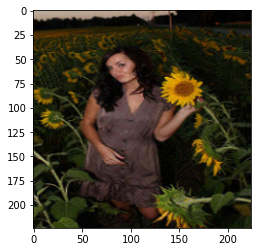

After adversaries
Predicted label: dandelion


In [31]:
# Let's see this in action
perturb_image(model, sample_val_image, CLASSES.index(sample_val_image.split("/")[1]), 1)

## Adversarial training

In [32]:
# Setup Neural Structured Learning
!pip install --quiet neural-structured-learning
import neural_structured_learning as nsl

     |████████████████████████████████| 112kB 2.8MB/s 


In [0]:
# NSL wouldn't support ImageDataGenerator, so,
# let's create NumPy arrays
def create_numpy_arrays(split):
    images = []
    labels = []

    # Gather the image paths and shuffle train paths
    all_paths = list(paths.list_images(split))
    if split == "train":
        random.shuffle(all_paths)

    # Iterate and process
    for image_path in tqdm(all_paths):
        image = plt.imread(image_path)
        label = image_path.split("/")[1]
        image = cv2.resize(image, (224, 224))
        image = image/255.

        images.append(image)
        labels.append(label)

    return (np.array(images), np.array(labels))

In [139]:
# And shoot!
X_train, y_train = create_numpy_arrays("train")
X_val, y_val = create_numpy_arrays("val")

100%|██████████| 550/550 [00:01<00:00, 278.18it/s]


In [140]:
# Verify the shapes
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((3120, 224, 224, 3), (3120,), (550, 224, 224, 3), (550,))

In [141]:
# One-hot encode
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()
y_train_enc = lb.fit_transform(y_train)
y_val_enc = lb.transform(y_val)

y_train_ohe = tf.keras.utils.to_categorical(y_train_enc)
y_val_ohe = tf.keras.utils.to_categorical(y_val_enc)

y_train_ohe.shape, y_val_ohe.shape

((3120, 5), (550, 5))

In [0]:
# Create TensorFlow dataset
train_ds = (
    tf.data.Dataset
    .from_tensor_slices({"image": X_train, "label": y_train_ohe})
    .repeat()
    .batch(32)
    .prefetch(100)
)
val_ds = (
    tf.data.Dataset
    .from_tensor_slices({"image": X_val, "label": y_val_ohe})
    .repeat()
    .batch(32)
    .prefetch(100)
)

In [0]:
# Configuration for adversarial training
adv_config = nsl.configs.make_adv_reg_config(
    multiplier=0.2,
    adv_step_size=0.2,
    adv_grad_norm="infinity"
)

In [0]:
def get_adv_training_model():
    # We are not training the extractor model
    EXTRACTOR.trainable = False
    # Construct the head of the model that will be placed on top of the
    # the base model
    class_head = EXTRACTOR.output
    class_head = GlobalAveragePooling2D()(class_head)
    class_head = Dense(512, activation="relu")(class_head)
    class_head = Dropout(0.5)(class_head)
    class_head = Dense(5, activation="softmax")(class_head)

    # Create the new model
    classifier = Model(inputs=EXTRACTOR.input, outputs=class_head)

    return classifier

In [145]:
# Create and compile the adv. model
base_adv_model = get_adv_training_model()
adv_model = nsl.keras.AdversarialRegularization(
    base_adv_model,
    adv_config=adv_config
)

adv_model.compile(loss="categorical_crossentropy", 
                          optimizer="adam",
                          metrics=["accuracy"])

# Train the model
start = time.time()
h = adv_model.fit(train_ds,
              steps_per_epoch=3120//32,
              validation_data=val_ds,
              validation_steps=550//32,
              epochs=10)
print("Total training time: ",time.time()-start)

Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

97/97 [==============================] - 16s 162ms/step - loss: 0.9658 - categorical_crossentropy: 0.6544 - categorical_accuracy: 0.7668 - adversarial_loss: 1.5569 - val_loss: 0.5537 - val_categorical_crossentropy: 0.2983 - val_categorical_accuracy: 0.9007 - val_adversarial_loss: 1.2770
Epoch 2/10
97/97 [==============================] - 13s 135ms/step - loss: 0.6044 - categorical_crossentropy: 0.3482 - categorical_accuracy: 0.8798 - adversarial_loss: 1.2810 - val_loss: 0.4481 - val_categoric

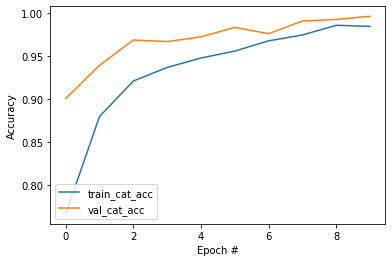

In [146]:
N = len(h.history["loss"])
plt.figure()
plt.plot(np.arange(0, N), h.history["categorical_accuracy"], label="train_cat_acc")
plt.plot(np.arange(0, N), h.history["val_categorical_accuracy"], label="val_cat_acc")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.show()

The accuracy of this model is not anywhere near our previous model's accuracy. Now, we will test the robustness of the above two models under adversarial perturbations as shown in [this tutorial](https://www.tensorflow.org/neural_structured_learning/tutorials/adversarial_keras_cnn_mnist#robustness_under_adversarial_perturbations). Most of the code below comes from that tutorial itself. 

In [0]:
# Compile the base model after wrapping it with `AdversarialRegularization`
# Needed to generate perturbated samples
reference_model = nsl.keras.AdversarialRegularization(
    model,
    adv_config=adv_config)
reference_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"])

In [0]:
# Models to be evaluated
models_to_eval = {
    'base': model,
    'adv-regularized': adv_model.base_model
}
metrics = {
    name: tf.keras.metrics.CategoricalAccuracy()
    for name in models_to_eval.keys()
}

In [149]:
# Comes from the above-mentioned tutorial with some modification
perturbed_images, labels, predictions = [], [], []

val_ds = (
    tf.data.Dataset
    .from_tensor_slices({"image": X_val, "label": y_val_ohe})
    .batch(32)
)

for batch in val_ds:
    perturbed_batch = reference_model.perturb_on_batch(batch)
    # Clipping makes perturbed examples have the same range as regular ones.
    perturbed_batch["image"] = tf.clip_by_value(                          
        perturbed_batch["image"], 0.0, 1.0)
    y_true = perturbed_batch.pop("label")
    perturbed_images.append(perturbed_batch["image"].numpy())
    labels.append(y_true.numpy())
    predictions.append({})
    for name, model in models_to_eval.items():
        y_pred = model(perturbed_batch)
        metrics[name](y_true, y_pred)
        predictions[-1][name] = tf.argmax(y_pred, axis=-1).numpy()

for name, metric in metrics.items():
    print('%s model accuracy: %f' % (name, metric.result().numpy()))

base model accuracy: 0.670909
adv-regularized model accuracy: 0.687273


With more training the adversarial model's performance could be more improved. 

accuracy in batch 1:
base model: 22 / 32
adv-regularized model: 23 / 32


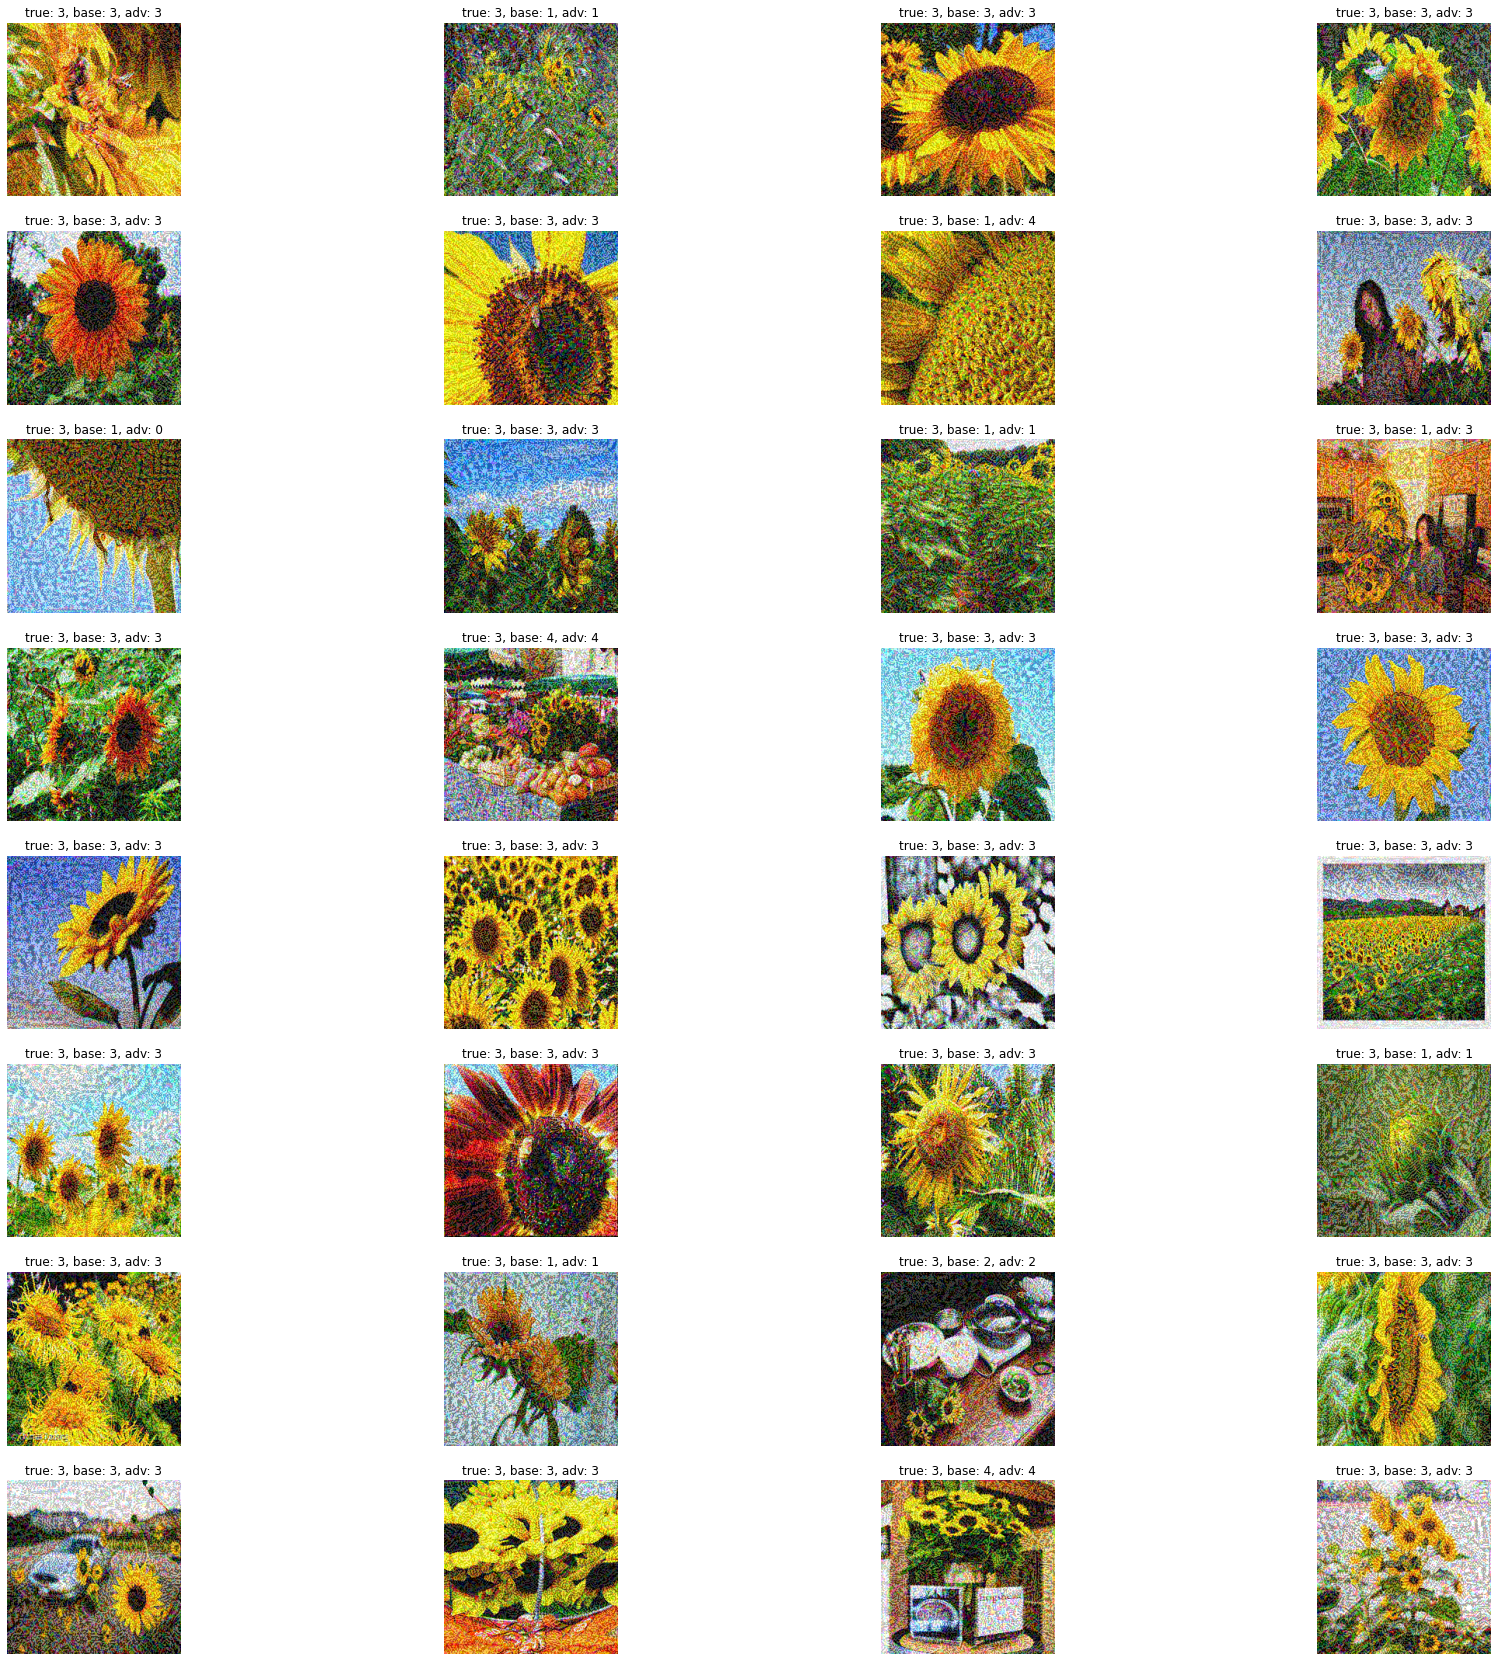

In [152]:
# Comes from the above-mentioned tutorial with some modification
batch_index = 1

batch_image = perturbed_images[batch_index]
batch_label = labels[batch_index]
batch_pred = predictions[batch_index]

batch_size = 32
n_col = 4
n_row = (batch_size + n_col - 1) / n_col

print('accuracy in batch %d:' % batch_index)
for name, pred in batch_pred.items():
    print('%s model: %d / %d' % (name, np.sum(np.argmax(batch_label) == pred), batch_size))

plt.figure(figsize=(30, 30))
for i, (image, y) in enumerate(zip(batch_image, batch_label)):
    y_base = batch_pred['base'][i]
    y_adv = batch_pred['adv-regularized'][i]
    y = np.argmax(y)
    plt.subplot(n_row, n_col, i+1)
    plt.title('true: {}, base: {}, adv: {}'.format(y, y_base, y_adv))
    plt.imshow(tf.keras.preprocessing.image.array_to_img(image))
    plt.axis('off')

plt.show()